In [1]:
import pandas as pd
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score
import numpy as np
from wordcloud import WordCloud
import gc

In [3]:
train = pd.read_csv('train_spam.csv')
test = pd.read_csv('test_spam.csv')

Базовая аналитика

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  16278 non-null  object
 1   text       16278 non-null  object
dtypes: object(2)
memory usage: 254.5+ KB


In [5]:
train.head(5)

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [6]:
train[train.duplicated()]

,text_type,text
4145,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
4463,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
5640,ham,/ban
6933,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
7663,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
7918,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
9790,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
10290,ham,SPAM DETECTION User: Username: @DillyBubb...
10811,ham,SPAM DETECTION User: Username: @DillyBubb...
13210,ham,SPAM DETECTION User: Username: @DillyBubb...


In [7]:
train.drop_duplicates(keep = 'first',inplace=True)

In [8]:
train.rename(columns={'text_type':'spam'},inplace=True)
train['spam'] = train['spam'].map({'spam':1,'ham':0})

In [9]:
train.head(5)

,spam,text
0,0,make sure alex knows his birthday is over in f...
1,0,a resume for john lavorato thanks vince i will...
2,1,plzz visit my website moviesgodml to get all m...
3,1,urgent your mobile number has been awarded wit...
4,0,overview of hr associates analyst project per ...


In [10]:
train['text'] = train['text'].str.replace(r'[^\w\s]', '', regex=True)
train['text'] = train['text'].str.lower()
test['new_text'] = test['text'].str.replace(r'[^\w\s]', '', regex=True)
test['new_text'] = test['new_text'].str.lower()

In [11]:
stop = stopwords.words('english')
train['text'] = train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test['new_text'] = test['new_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

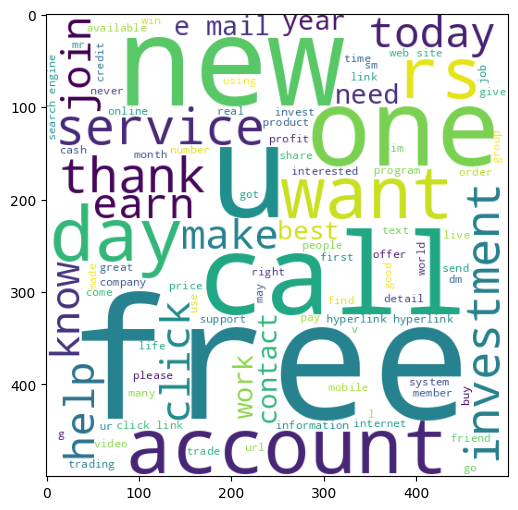

In [12]:
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'white')
spam_wc = wc.generate(train[train['spam'] == 1]['text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(spam_wc)
plt.show()

Наиболее популярным словом в спаме является слово free (ожидаемо)

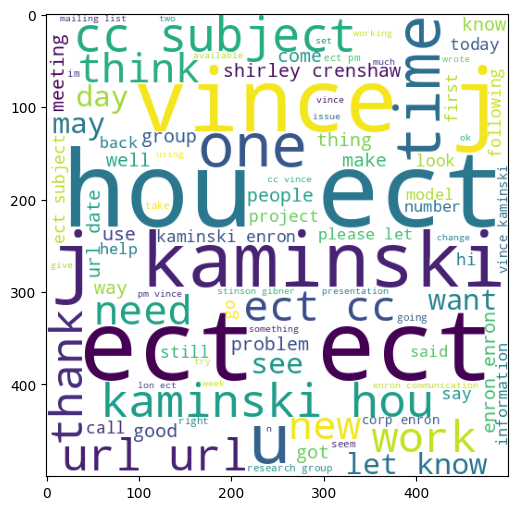

In [13]:
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'white')
spam_wc = wc.generate(train[train['spam'] == 0]['text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(spam_wc)
plt.show()

Облако слов для не спам сообщений

In [14]:
dist = train.spam.value_counts()

In [15]:
ham = dist.iloc[0]/len(train)*100
spam = dist.iloc[1]/len(train)*100

классы не сбалансированны

In [16]:
print(f'ham:{ham:.2f}%, spam:{spam:.2f}%')

ham:70.44%, spam:29.56%


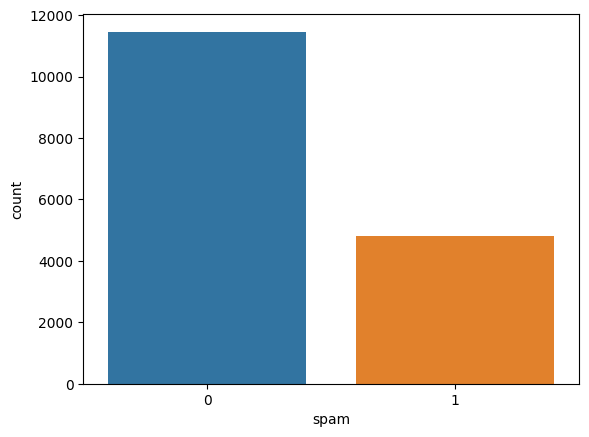

In [17]:
sns.countplot(data=train, x='spam')
plt.show()

In [18]:
spam_messages = train[train['spam'] == 1].text
spam_text = ' '.join(spam_messages)
words = spam_text.lower().split()
word_counts = Counter(words)
top_words = word_counts.most_common(20)

In [19]:
top_words

[('1635465', 1568),
 ('free', 1081),
 ('get', 869),
 ('1', 695),
 ('new', 568),
 ('click', 557),
 ('2', 554),
 ('call', 524),
 ('link', 524),
 ('one', 488),
 ('com', 479),
 ('money', 474),
 ('please', 470),
 ('5', 467),
 ('time', 429),
 ('best', 428),
 ('business', 427),
 ('account', 427),
 ('3', 427),
 ('company', 413)]

(1635465???) основные слова в спаме -['free', 'get', 'money', 'click']

проверим где и как встречается это немалое число

In [20]:
filtered_messages = train[train['text'].str.contains('1635465', case=False)]

In [21]:
filtered_messages.spam.value_counts()

spam
0    1581
1     252
Name: count, dtype: int64

в спам сообщениях это число встречается реже чем не в спам.

In [22]:
filtered_messages.iloc[230].text

'friends brand new idea live webcam hyperlink click spam received e mail one time another entered weekly draw one portals ffa sites comply proposed current laws commercial e mail bill 1635465 title iii passed 1635465th congress received e mail error apologize inconvenience ask remove click hyperlink unsubscribe cvstceuyxxkxgnxskjnc'

Природа этого магического числа мне не ясна. Появляется в странном контексте. Думаю это ошибка генерации текста и лучше удалить, чтобы не путать модель.

In [23]:
train['text'] = train['text'].str.replace('1635465', '')
test['new_text'] = test['new_text'].str.replace('1635465', '')

In [24]:
spam_messages = train[train['spam'] == 0].text
spam_text = ' '.join(spam_messages)
words = spam_text.lower().split()
word_counts = Counter(words)
top_words = word_counts.most_common(20)

In [25]:
top_words

[('ect', 5343),
 ('enron', 4848),
 ('vince', 4525),
 ('url', 3617),
 ('hou', 2660),
 ('kaminski', 2365),
 ('2000', 2204),
 ('subject', 2110),
 ('j', 1928),
 ('cc', 1909),
 ('pm', 1896),
 ('please', 1888),
 ('com', 1852),
 ('would', 1849),
 ('u', 1443),
 ('like', 1423),
 ('thanks', 1407),
 ('time', 1372),
 ('2001', 1347),
 ('know', 1340)]

в не спам сообщениях вроде бы нет ничего подозрительного

In [26]:
spam_messages = train[train['spam'] == 1]
non_spam_messages = train[train['spam'] == 0]
spam_message_lengths = spam_messages['text'].str.len()
non_spam_message_lengths = non_spam_messages['text'].str.len()
spam_length_distribution = spam_message_lengths.value_counts().sort_index()
non_spam_length_distribution = non_spam_message_lengths.value_counts().sort_index()

In [27]:
print('средняя длина спам сообщений:')
print(spam_length_distribution.mean())
print("\nсредняя длина не спам сообщений:")
print(non_spam_length_distribution.mean())

средняя длина спам сообщений:
7.286363636363636

средняя длина не спам сообщений:
16.65406976744186


Лемматизация сообщений

In [28]:


nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])


train['text'] = train['text'].apply(lemmatize_text)
test['new_text'] = test['new_text'].apply(lemmatize_text)




Векторизация. Использую TF-IDF

In [29]:
vectorizer = TfidfVectorizer()
train_matrix = vectorizer.fit_transform(train['text'])
test_matrix = vectorizer.transform(test['new_text'])

In [30]:
X = train_matrix.toarray()
y = train.spam.values

разбил данные на тренировочную часть и тестовую

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=54)

In [32]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

модели  

In [33]:
knn = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth = 5)
lrc = LogisticRegression(solver = 'liblinear', penalty = 'l1')
rfc = RandomForestClassifier(n_estimators = 40, random_state = 54 )
xgb  = XGBClassifier(n_estimators = 20, random_state = 54)

In [34]:
clfs = {
    
 'KNN': knn,
   'NaiveBayes': mnb,
   'DT': dtc,
  'R': lrc,
    'RF': rfc,
    'xgb': xgb
  
}

с помощью K-Fold кросс валидации выберу лучшую модель.

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=54)
for clf_name,clf in clfs.items():
    
    cross_val_scores = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=skf)
    print(f'Средний ROC AUC для {clf_name}: {np.mean(cross_val_scores):.2f}')
    del clf
    gc.collect()

ожидаемый результат. KNN показал себя хуже всех. Дело в том что в NLP задачах получается много фич, а слабое место метода ближайших соседей как раз и есть большая размерность. Так же ожидаемо, что RF показал результат лучше всех. Лес Хорошо справляется с несбалансированными метками. Дальше буду использовать RF. Логистическая Регрессия обучается почти мгновенно, в отличии от леса, а скор отличается совсем немного. Логично было бы использовать именно регрессию, но в задании не было сказанно что больше ценится(время выполнения или скор), так что пусть будет лес.

обучаем лучшую модель

In [35]:
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=40, random_state=54)

тест лучшей модели

In [36]:
y_pred_proba = rfc.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'ROC AUC на тестовом наборе данных: {roc_auc:.2f}')

ROC AUC на тестовом наборе данных: 0.98


In [37]:
testX = test_matrix.toarray()

предсказание для тестовых данных

In [38]:
test_preds = rfc.predict_proba(testX)[:,1]

In [39]:
test['score'] = test_preds

In [43]:
test.drop(['new_text'],axis =1,inplace=True)

In [44]:
test

,text,score
0,j jim whitehead ejw cse ucsc edu writes j you ...,0.100000
1,original message from bitbitch magnesium net p...,0.325000
2,java for managers vince durasoft who just taug...,0.075000
3,there is a youtuber name saiman says,0.002778
4,underpriced issue with high return on equity t...,0.225000
...,...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...,0.021032
4066,baylor enron case study cindy yes i shall co a...,0.000000
4067,boring as compared to tp,0.107328
4068,hellogorgeous hows u my fone was on charge lst...,0.176923


In [45]:
test.to_csv('submition.csv',index=False)